In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

df = pd.read_csv("../data/processed/macro_panel.csv")
df["month_dt"] = pd.to_datetime(df["month"])

In [2]:
df = df.sort_values(["country","month_dt"])
df["rti_growth"] = df.groupby("country")["rti_index"].pct_change() * 100

In [3]:
country_mean = (
    df.groupby("country")
      .agg(
          mean_growth=("rti_growth","mean"),
          vol_growth=("rti_growth","std")
      )
      .sort_values("mean_growth", ascending=False)
)

country_mean

,mean_growth,vol_growth
country,,
FR,0.303633,4.402090
DE,0.139763,2.098356
AT,0.078718,4.014756
FI,0.075752,1.107711
NL,0.071745,2.279938
ES,0.021883,3.134760
IT,-0.009893,3.187398


- Countries differ more in **volatility** than in average growth
- Southern economies show higher dispersion
- Core economies are more stable but not necessarily faster growing

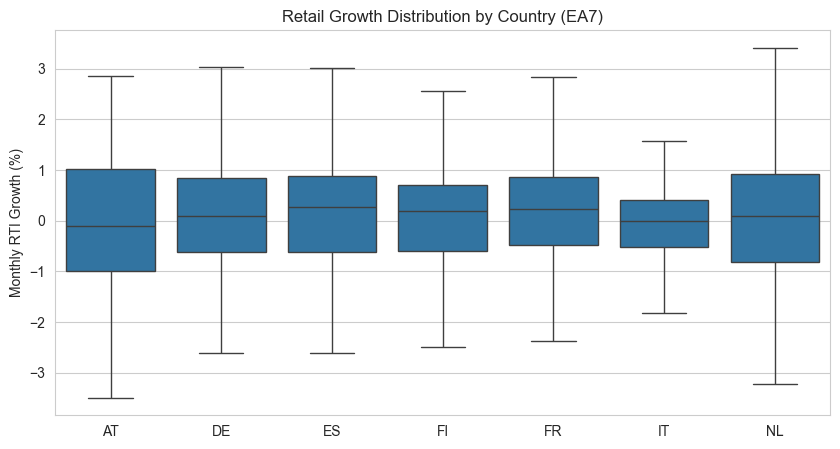

In [4]:
plt.figure(figsize=(10,5))
sns.boxplot(
    data=df,
    x="country",
    y="rti_growth",
    showfliers=False
)
plt.title("Retail Growth Distribution by Country (EA7)")
plt.ylabel("Monthly RTI Growth (%)")
plt.xlabel("")
plt.show()

Retail volatility is **structural,** not random.

In [5]:
sens = []

for c in df["country"].unique():
    sub = df[df["country"] == c].dropna(subset=["rti_growth","hicp_index"])
    beta = np.cov(sub["rti_growth"], sub["hicp_index"])[0,1] / np.var(sub["hicp_index"])
    sens.append((c, beta))

infl_sens = pd.DataFrame(sens, columns=["country","inflation_beta"])
infl_sens.sort_values("inflation_beta")

,country,inflation_beta
3,FI,-0.011461
1,DE,-0.011180
4,FR,-0.007616
5,IT,-0.006503
0,AT,-0.004989
6,NL,-0.001644
2,ES,0.023546


- Negative betas → inflation-sensitive retail demand
- Countries differ markedly in exposure

In [6]:
sens = []

for c in df["country"].unique():
    sub = df[df["country"] == c].dropna(subset=["rti_growth","cci"])
    beta = np.cov(sub["rti_growth"], sub["cci"])[0,1] / np.var(sub["cci"])
    sens.append((c, beta))

cci_sens = pd.DataFrame(sens, columns=["country","cci_beta"])
cci_sens.sort_values("cci_beta", ascending=False)

,country,cci_beta
4,FR,0.058536
5,IT,0.031558
1,DE,0.028191
6,NL,0.016715
3,FI,0.016002
0,AT,0.012821
2,ES,0.010825


Retail in some countries is **confidence-driven,** not price-driven.

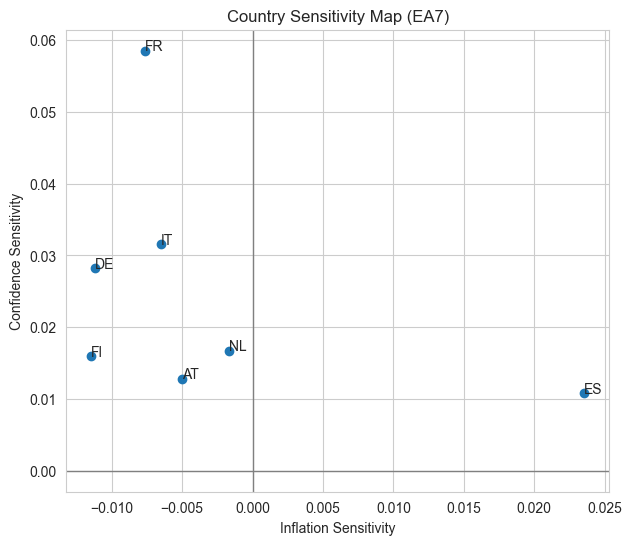

In [7]:
merged = infl_sens.merge(cci_sens, on="country")

plt.figure(figsize=(7,6))
plt.scatter(merged["inflation_beta"], merged["cci_beta"])

for _, r in merged.iterrows():
    plt.text(r["inflation_beta"], r["cci_beta"], r["country"])

plt.axhline(0, color="gray", lw=1)
plt.axvline(0, color="gray", lw=1)

plt.xlabel("Inflation Sensitivity")
plt.ylabel("Confidence Sensitivity")
plt.title("Country Sensitivity Map (EA7)")
plt.show()

- **Top-left**: confidence-driven, inflation-resistant
- **Bottom-right**: inflation-vulnerable, weak confidence channel
- **Top-right**: highly macro-sensitive economies

In [8]:
# Define macro regimes based on inflation (same logic as Notebook 04)

df["regime"] = pd.cut(
    df["hicp_index"],
    bins=[-np.inf, 115, 130, np.inf],
    labels=["Low inflation", "Moderate inflation", "High inflation"]
)

### Macro Regime Classification

We classify inflation regimes using the HICP index, consistent with Notebook 04, to ensure comparability while keeping this notebook self-contained.

/var/folders/h3/p7wl5qls22b6g1rct6ljfgvc0000gn/T/ipykernel_4597/2079006014.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(["country","regime"])


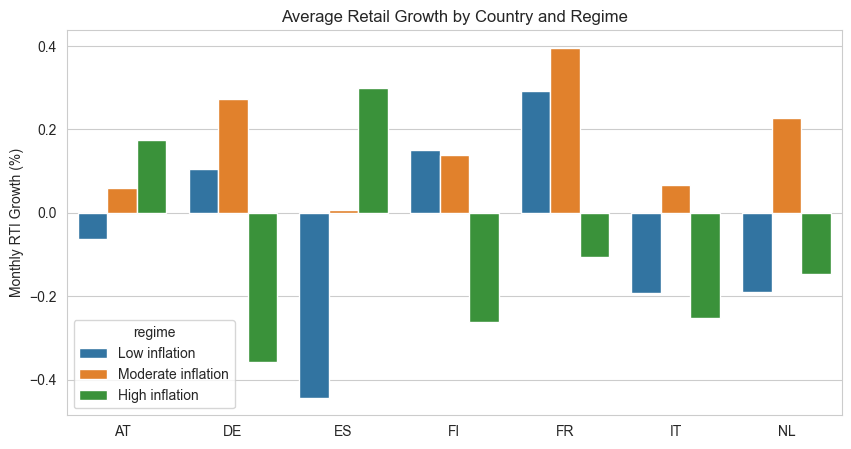

In [9]:
regime_growth = (
    df.groupby(["country","regime"])
      .agg(mean_growth=("rti_growth","mean"))
      .reset_index()
)

plt.figure(figsize=(10,5))
sns.barplot(
    data=regime_growth,
    x="country",
    y="mean_growth",
    hue="regime"
)
plt.title("Average Retail Growth by Country and Regime")
plt.ylabel("Monthly RTI Growth (%)")
plt.xlabel("")
plt.show()

Regimes dominate outcomes, but country structure still matters.

In [10]:
final_summary = (
    country_mean
    .merge(merged, on="country")
    .sort_values("mean_growth", ascending=False)
)

final_summary

,country,mean_growth,vol_growth,inflation_beta,cci_beta
0,FR,0.303633,4.402090,-0.007616,0.058536
1,DE,0.139763,2.098356,-0.011180,0.028191
2,AT,0.078718,4.014756,-0.004989,0.012821
3,FI,0.075752,1.107711,-0.011461,0.016002
4,NL,0.071745,2.279938,-0.001644,0.016715
5,ES,0.021883,3.134760,0.023546,0.010825
6,IT,-0.009893,3.187398,-0.006503,0.031558


**Key Findings**
1. Retail behavior is not homogeneous across EA7
2. Volatility differences dominate level differences
3. Inflation sensitivity varies strongly by country
4. Confidence channel is stronger in some economies
5. Macro regime explains most variation, country structure explains the rest